In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'train.csv', 'sample_submission.csv', 'class.csv', 'test', 'test.csv']


In [25]:
import seaborn as sns
import matplotlib.pylab as plt
import PIL
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, models, optimizers

In [26]:
DATA_PATH = '../input'
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [27]:
nb_train_sample = df_train.shape[0] * 0.7
nb_validation_sample = df_train.shape[0] - nb_train_sample
nb_test_sample = df_test.shape[0]

In [28]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


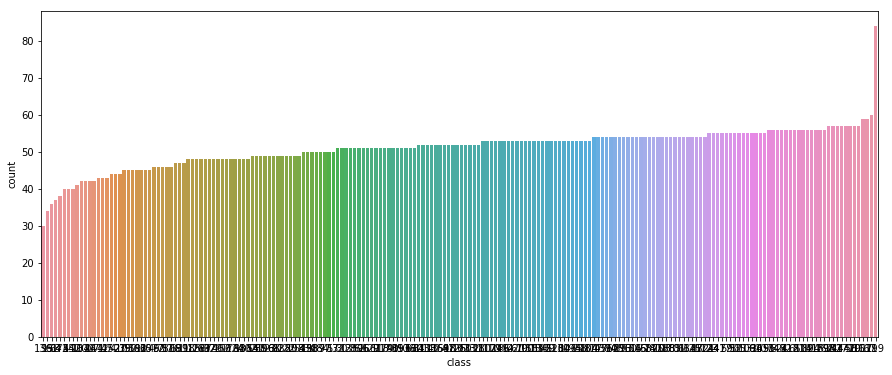

In [29]:
plt.figure(figsize=(15,6))
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)

In [30]:
df_train['class'].value_counts().describe()

count    196.000000
mean      51.102041
std        5.350274
min       30.000000
25%       48.750000
50%       52.000000
75%       54.000000
max       84.000000
Name: class, dtype: float64

In [31]:
df_train['class'].value_counts().mean()

51.10204081632653

In [32]:
img_size=224

def crop_boxing_img(img_name, margin=16, imsize=(img_size, img_size)):
    if img_name.split('_')[0] == 'train':
        PATH = TRAIN_IMG_PATH
        data = df_train
    else:
        PATH = TEST_IMG_PATH
        data = df_test

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1, y1, x2, y2)).resize(imsize)

In [33]:
nb_train_sample = df_train.shape[0] * 0.8
nb_validation_sample = df_train.shape[0] - nb_train_sample
nb_test_sample = df_test.shape[0]

In [34]:
TRAIN_CROPPED_PATH = '../cropped_train'
TEST_CROPPED_PATH = '../cropped_test'
VALID_CROPPED_PATH = '../cropped_valid'
if (os.path.isdir(TRAIN_CROPPED_PATH) == False):
    os.mkdir(TRAIN_CROPPED_PATH)
if (os.path.isdir(TEST_CROPPED_PATH) == False):
    os.mkdir(TEST_CROPPED_PATH)
if (os.path.isdir(VALID_CROPPED_PATH) == False):
    os.mkdir(VALID_CROPPED_PATH)
    

In [35]:
df_train["class"] = df_train["class"].astype('str')

for i, row in df_train.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    
    if ( i < nb_train_sample):
        class_path = os.path.join(TRAIN_CROPPED_PATH, df_train['class'][i])
        if(os.path.isdir(class_path) == False):
            os.mkdir(class_path)

        cropped.save(os.path.join(class_path, row['img_file']))
    else:
        class_path = os.path.join(VALID_CROPPED_PATH, df_train['class'][i])
        if(os.path.isdir(class_path) == False):
            os.mkdir(class_path)

        cropped.save(os.path.join(class_path, row['img_file']))

for i, row in df_test.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(os.path.join(TEST_CROPPED_PATH, row['img_file']))

In [65]:
batch_size=32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    fill_mode='nearest'
    )
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [66]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_CROPPED_PATH,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=2019,
    color_mode='rgb'
)
validation_generator = valid_datagen.flow_from_directory(
    VALID_CROPPED_PATH,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=2019,
    color_mode='rgb'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROPPED_PATH,
    x_col='img_file',
    y_col=None,
    target_size=(img_size, img_size),
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 8013 images belonging to 196 classes.
Found 2003 images belonging to 196 classes.
Found 6169 validated image filenames.


In [67]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

inception_module = InceptionV3(weights='imagenet',include_top=False, input_shape = (224,224,3))
model = models.Sequential()
model.add(inception_module)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(196, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 196)               200900    
Total params: 24,101,860
Trainable params: 24,067,428
Non-trainable params: 34,432
_________________________________________________________________


In [68]:
optimizer = optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])


In [69]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [ ]:
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
callbackList = [es]
epochs=300
history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_sample, batch_size),
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_sample, batch_size),
    callbacks = callbackList
)

Epoch 1/300
251/251 [==============================] - 205s 815ms/step - loss: 5.2171 - acc: 0.0136 - val_loss: 4.9582 - val_acc: 0.0330
Epoch 2/300
251/251 [==============================] - 117s 466ms/step - loss: 4.2334 - acc: 0.1085 - val_loss: 3.2339 - val_acc: 0.2391
Epoch 3/300
211/251 [========================>.....] - ETA: 17s - loss: 2.9055 - acc: 0.3018

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Traing loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Trainging and validation loss')
plt.legend()
plt.show()